# Deep Reinforcement Learning with Atari Games
*   Play the game and record each frame (state) and action as the input and the corresponding reward as the output
*   Each frame is just an image and hence train CNN (Convolutional Neural Network) to approximate the input images (states and actions) to the output rewards relationships
*   Supervised Learning learns Relationship (Classification / Regression); RL learns Policy (Strategy)

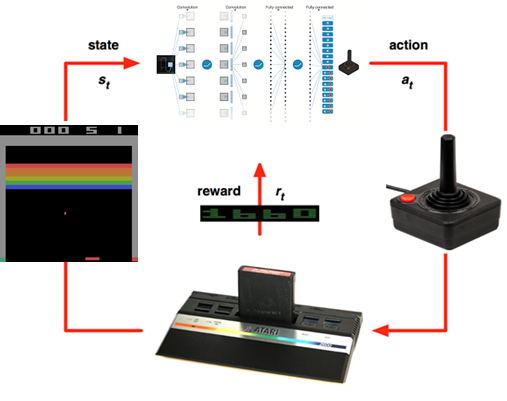

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

### Install libraries

# Re-install gym with a specific version
!pip install gym==0.19.0
!pip install keras-rl2
#!apt-get install -y cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/dqn_BreakoutDeterministic-v4_weights_1750000.h5f
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/BreakoutDeterministic-v4.bin
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/MsPacman-v0.bin
!python -m atari_py.import_roms .


### Import libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display as displayScreen
from IPython.display import clear_output
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import gym
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.callbacks import Callback

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

# Subclass to visualize on Jupyter Notebook, inherits from rl.callbacks.Callback Class
class Render(Callback):
    def on_step_end(self, step, logs={}):
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

SIZE_X, SIZE_Y = 12, 7.5

ACTION_DICT = {'Stand':0, 'Start':1, 'Right':2, 'Left':3}

def showEnv(env, action):
  obs, reward, done, info = env.step(action)
  print("Reward:",reward, "  Completed:",done, "  Info:",info) 
  plt.figure(figsize=(SIZE_X, SIZE_Y))
  plt.imshow(obs)
  

In [ ]:
#@title Start a "Breakout" game and manually play with the possible actions

ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME)
env.reset()

def button_eventhandler(change):
  clear_output(wait=True)
  displayScreen(buttonStart, buttonLeft, buttonRight, buttonStand)
  showEnv(env, ACTION_DICT[change.description])
  
  
# Show possible Actions buttons: 0=no, 1=start, 2=right, 3=left"
buttonStart = widgets.Button(
    description='Start'
)
buttonStart.on_click(button_eventhandler)

buttonLeft = widgets.Button(
    description='Left'
)
buttonLeft.on_click(button_eventhandler)

buttonRight = widgets.Button(
    description='Right'
)
buttonRight.on_click(button_eventhandler)

buttonStand = widgets.Button(
    description='Stand'
)
buttonStand.on_click(button_eventhandler)

displayScreen(buttonStart, buttonLeft, buttonRight, buttonStand)
showEnv(env, 0)

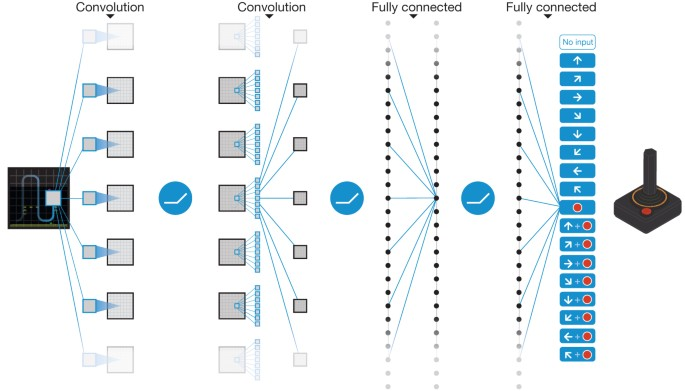

In [ ]:
#@title Combine the CNN (Convolutional Neural Network) and the Reinforcement Learning Model
training_steps = 1000 #@param {type:"integer"}

INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
callbacks = Render()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])


# Train the model and display the results
plt.figure(figsize=(SIZE_X, SIZE_Y))
dqn.fit(env, nb_steps=training_steps, log_interval=1000)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])


In [ ]:
#@title Load and use a pre-trained weightes (after 1.7 million steps of training)

plt.figure(figsize=(SIZE_X, SIZE_Y))
weights_filename = 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f'
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

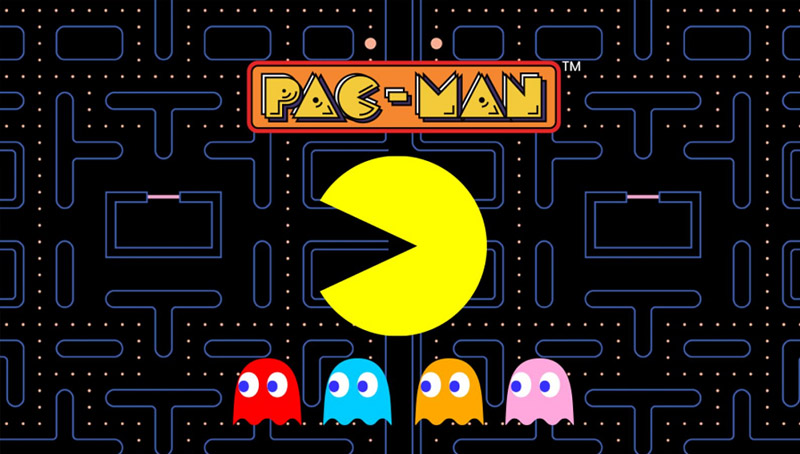

In [ ]:
#@title Use Deep Reinforcement Learning and train 1000 steps to play Pac-Man

# Pacman Game
ENV_NAME = 'MsPacman-v0'
env = gym.make(ENV_NAME)

nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
callbacks = Render()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])

# Train the model and display the results
plt.figure(figsize=(SIZE_X, SIZE_Y))
dqn.fit(env, nb_steps=1000, log_interval=1000)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])